In [1]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
edges_df = pd.read_csv('GNN/protein_interactions.csv')

col_name = ['protein']
for i in range(1,769):
  col_name.append('feature'+str(i))
features_df = pd.read_csv('GNN/gene_embedding_GeneLLM_2.csv', header=None, names=col_name)

print(features_df)
labels_df = pd.read_csv('GNN/solubility.csv')

/tmp/ipykernel_4012237/1133472201.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tmp/ipykernel_4012237/1133472201.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv('GNN/protein_interactions.csv')


      protein  feature1  feature2  feature3  feature4  feature5  feature6  \
0         FES  0.339602 -0.030744 -0.901381  0.100888  0.886443  0.383596   
1      HADHA  -0.131799 -0.025745 -0.677301 -0.053545  0.971046  0.180315   
2      SLC7A7  0.385693 -0.070692 -0.847796 -0.022054  0.959772  0.085487   
3        LCK   0.650428  0.014479 -0.866163  0.053508  0.951529  0.269402   
4       HSPA2  0.322262  0.017484 -0.849302  0.046401  0.920429  0.463832   
...       ...       ...       ...       ...       ...       ...       ...   
14445   BPY2C -0.840158 -0.042814 -0.853394 -0.049438  0.943925  0.104337   
14446    CLPS -0.270716 -0.036871 -0.915350 -0.013635  0.972046  0.016017   
14447    DNER  0.228932 -0.033579 -0.907262  0.010446  0.961684  0.524211   
14448    SOX7  0.140491  0.033339 -0.806014 -0.072016  0.938781  0.339959   
14449  CXCL14 -0.570266 -0.011502 -0.741149 -0.096209  0.967244  0.426519   

       feature7  feature8  feature9  ...  feature759  feature760  feature76

In [2]:
print(labels_df)
edges_df['combined_score'][7] = 594
edges_df_cleaned = edges_df.dropna()
print(edges_df_cleaned)
edges_df_cleaned = edges_df.dropna()
print(edges_df_cleaned)

     Gene name Solubility  Label  Word_Count Count_Category
0        ERAP2   Membrane      0         117     High Count
1     ADAMTSL5    Soluble      1          28      Low Count
2      TBC1D30   Membrane      0          55     High Count
3       KCNK18   Membrane      0         184     High Count
4         NDNF    Soluble      1         129     High Count
...        ...        ...    ...         ...            ...
1374   TRABD2B   Membrane      0          96     High Count
1375      RPS9    Soluble      1         205     High Count
1376  SLC22A16   Membrane      0          93     High Count
1377      FBN3    Soluble      1          90     High Count
1378      BDH2    Soluble      1         102     High Count

[1379 rows x 5 columns]


/tmp/ipykernel_4012237/3707133632.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges_df['combined_score'][7] = 594


         protein1  protein2 combined_score
0            ARF5   RALGPS2            173
1            ARF5     FHDC1            154
2            ARF5  ATP6V1E1            151
3            ARF5     CYTH2            471
4            ARF5      PSD3            201
...           ...       ...            ...
13715123     LDB1    SAMD14            260
13715124     LDB1     KDM6B            161
13715125     LDB1      WWP2            229
13715126     LDB1    VPS33B            152
13715127     LDB1     NDST2            440

[13067419 rows x 3 columns]
         protein1  protein2 combined_score
0            ARF5   RALGPS2            173
1            ARF5     FHDC1            154
2            ARF5  ATP6V1E1            151
3            ARF5     CYTH2            471
4            ARF5      PSD3            201
...           ...       ...            ...
13715123     LDB1    SAMD14            260
13715124     LDB1     KDM6B            161
13715125     LDB1      WWP2            229
13715126     LDB1    VPS3

In [3]:
node_id_f = [node_id for node_id in features_df['protein']]
node_id_e1 = [node_id for node_id in edges_df_cleaned['protein1']]
node_id_e2 = [node_id for node_id in edges_df_cleaned['protein2']]
node_id_e = list(set(node_id_e1 + node_id_e2))
print(len(node_id_f))
print(len(node_id_e))

14450
18838


In [4]:
labels_df.rename(columns={'Gene name': 'protein'}, inplace=True)
labels_df

,protein,Solubility,Label,Word_Count,Count_Category
0,ERAP2,Membrane,0,117,High Count
1,ADAMTSL5,Soluble,1,28,Low Count
2,TBC1D30,Membrane,0,55,High Count
3,KCNK18,Membrane,0,184,High Count
4,NDNF,Soluble,1,129,High Count
...,...,...,...,...,...
1374,TRABD2B,Membrane,0,96,High Count
1375,RPS9,Soluble,1,205,High Count
1376,SLC22A16,Membrane,0,93,High Count
1377,FBN3,Soluble,1,90,High Count


In [5]:
# 从边数据集获取节点
nodes_in_edges = set(edges_df_cleaned['protein1']).union(set(edges_df_cleaned['protein2']))

# 从特征数据集获取节点
nodes_in_features = set(features_df['protein'])

# 找出共同的节点
common_nodes = nodes_in_edges.intersection(nodes_in_features)

# 过滤边数据集，保留只包含共同节点的边
filtered_edges_df = edges_df_cleaned[edges_df_cleaned['protein1'].isin(common_nodes) & edges_df_cleaned['protein2'].isin(common_nodes)].reset_index(drop=True)

# 过滤特征数据集，保留共同节点的特征
filtered_features_df = features_df[features_df['protein'].isin(common_nodes)].reset_index(drop=True)

In [6]:
# 将第二列中的两种字符映射为0和1
unique_values = labels_df['Count_Category'].unique()
print(unique_values)
mapping = {unique_values[0]: 0, unique_values[1]: 1}

labels_df['Count_Category'] = labels_df['Count_Category'].map(mapping)
# 显示更新后的DataFrame
print(labels_df)

['High Count' 'Low Count']
       protein Solubility  Label  Word_Count  Count_Category
0        ERAP2   Membrane      0         117               0
1     ADAMTSL5    Soluble      1          28               1
2      TBC1D30   Membrane      0          55               0
3       KCNK18   Membrane      0         184               0
4         NDNF    Soluble      1         129               0
...        ...        ...    ...         ...             ...
1374   TRABD2B   Membrane      0          96               0
1375      RPS9    Soluble      1         205               0
1376  SLC22A16   Membrane      0          93               0
1377      FBN3    Soluble      1          90               0
1378      BDH2    Soluble      1         102               0

[1379 rows x 5 columns]


In [7]:
label_counts = labels_df['Label'].value_counts()
print(label_counts)

Label
1    709
0    670
Name: count, dtype: int64


In [8]:
node_id_to_index = {node_id: i for i, node_id in enumerate(filtered_features_df['protein'])}
# 确保edge_index是按照这个新的索引顺序排列的
source_indices = [node_id_to_index[node_id] for node_id in filtered_edges_df['protein1']]
target_indices = [node_id_to_index[node_id] for node_id in filtered_edges_df['protein2']]
edge_index = torch.tensor([source_indices, target_indices], dtype=torch.long)
filtered_edges_df['combined_score'] = pd.to_numeric(filtered_edges_df['combined_score'], errors='coerce', downcast='float')
edge_weight = torch.tensor(filtered_edges_df['combined_score'].values, dtype=torch.float)

# 重排特征矩阵以匹配edge_index的顺序
features = filtered_features_df.iloc[:, 1:].values
#features = features[[node_id_to_index[node_id] for node_id in filtered_features_df['protein']], :]

# 转换为PyTorch张量
features_tensor = torch.tensor(features, dtype=torch.float)

In [9]:
print(len(labels_df))
nodes_in_labels = set(labels_df['protein'])
nodes_in_filter_features = set(filtered_features_df['protein'])
common_nodes_labels = nodes_in_labels.intersection(nodes_in_filter_features)

# 过滤
filtered_labels_df = labels_df[labels_df['protein'].isin(common_nodes_labels)].reset_index(drop=True)
print(len(filtered_labels_df))
print(len(features_tensor))

1379
1355
14088


In [10]:
label_indices = [node_id_to_index[node_id] for node_id in filtered_labels_df['protein']]
print(label_indices)
num_nodes = 14088
labels = torch.full((num_nodes,), -1, dtype=torch.long)
for i, index in enumerate(filtered_labels_df['Label']):
    labels[label_indices[i]] = index

labels_tensor = torch.tensor(labels, dtype=torch.long)

[61, 75, 87, 88, 94, 109, 122, 135, 139, 140, 148, 157, 160, 192, 218, 225, 229, 231, 243, 246, 264, 269, 275, 282, 292, 305, 307, 319, 325, 354, 358, 360, 366, 367, 380, 383, 398, 422, 430, 449, 458, 459, 465, 473, 485, 492, 500, 532, 543, 559, 560, 561, 567, 568, 569, 570, 573, 588, 614, 625, 626, 636, 654, 707, 724, 732, 734, 743, 747, 751, 800, 817, 858, 859, 863, 878, 880, 901, 907, 920, 945, 959, 965, 981, 1002, 1009, 1015, 1024, 1025, 1026, 1028, 1035, 1036, 1039, 1040, 1066, 1069, 1076, 1077, 1080, 1084, 1091, 1096, 1097, 1103, 1117, 1130, 1133, 1143, 1154, 1155, 1156, 1174, 1193, 1194, 1200, 1213, 1218, 1219, 1229, 1230, 1232, 1264, 1268, 1279, 1285, 1299, 1314, 1322, 1328, 1329, 1334, 1343, 1348, 1377, 1378, 1382, 1386, 1395, 1396, 1419, 1420, 1425, 1434, 1439, 1442, 1443, 1470, 1476, 1489, 1497, 1508, 1524, 1542, 1555, 1558, 1563, 1565, 1567, 1585, 1586, 1593, 1622, 1629, 1658, 1668, 1681, 1684, 1685, 1706, 1723, 1742, 1754, 1770, 1779, 1780, 1790, 1794, 1795, 1798, 1800, 18

/tmp/ipykernel_4012237/4104203764.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels, dtype=torch.long)


In [11]:
highinfo_indices = [
    node_id_to_index[node_id]
    for node_id, weight in zip(filtered_labels_df['protein'], filtered_labels_df['Count_Category'])
    if weight == 0
]
print(highinfo_indices)
lowinfo_indices = [
    node_id_to_index[node_id]
    for node_id, weight in zip(filtered_labels_df['protein'], filtered_labels_df['Count_Category'])
    if weight == 1
]
print(lowinfo_indices)

[61, 87, 88, 94, 109, 122, 135, 139, 148, 157, 218, 225, 229, 243, 264, 275, 282, 307, 319, 325, 354, 358, 360, 366, 367, 380, 383, 398, 422, 449, 458, 465, 473, 485, 492, 500, 532, 543, 560, 561, 567, 568, 569, 570, 573, 588, 614, 626, 636, 654, 707, 724, 734, 747, 800, 817, 858, 859, 863, 878, 880, 901, 907, 920, 945, 959, 965, 981, 1002, 1015, 1024, 1025, 1026, 1028, 1035, 1036, 1039, 1040, 1066, 1069, 1076, 1077, 1080, 1084, 1091, 1096, 1097, 1103, 1117, 1130, 1133, 1143, 1154, 1155, 1156, 1174, 1193, 1194, 1200, 1213, 1218, 1229, 1230, 1232, 1264, 1268, 1279, 1285, 1299, 1314, 1328, 1329, 1343, 1348, 1378, 1395, 1396, 1419, 1420, 1425, 1434, 1439, 1442, 1443, 1470, 1497, 1508, 1524, 1542, 1558, 1563, 1565, 1567, 1585, 1586, 1622, 1629, 1668, 1681, 1684, 1685, 1706, 1723, 1742, 1754, 1779, 1780, 1790, 1795, 1798, 1800, 1825, 1836, 1838, 1841, 1857, 1860, 1866, 1901, 1911, 1913, 1918, 1926, 1935, 1955, 1970, 1985, 1987, 2010, 2033, 2034, 2038, 2046, 2051, 2053, 2073, 2084, 2087, 209

In [12]:
print(len(highinfo_indices))
print(len(lowinfo_indices))

1184
171


In [13]:
data = Data(x=features_tensor, edge_index=edge_index, y=labels_tensor, edge_attr=edge_weight)

print("x:", data.x.shape, data.x.dtype)
print("edge_index:", data.edge_index.shape, data.edge_index.dtype)
print("labels:", data.y.shape, data.y.dtype)
print("edge_weight:", data.edge_attr.shape, data.edge_attr.dtype)

x: torch.Size([14088, 768]) torch.float32
edge_index: torch.Size([2, 9503503]) torch.int64
labels: torch.Size([14088]) torch.int64
edge_weight: torch.Size([9503503]) torch.float32


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, edge_index, edge_weight):
        # 保存初始特征
        initial_features = x

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        # 在这里将初始特征和 GCN 的输出拼接在一起
        #x = torch.cat([x, initial_features], dim=1)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)   #应用 Sigmoid 激活函数进行逻辑回归
        return x


In [15]:
from sklearn.metrics import roc_auc_score
import numpy as np
import torch.optim.lr_scheduler

device = torch.device('cuda:1')
data = data.to(device)
# 加载数据
features = data.x
labels = data.y # 根据你的数据加载函数进行调整

original_features = features.clone()

# 初始化GNN模型
model = GCN(num_features=features.shape[1], hidden_dim=64, num_classes=1).to(device)
criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)

label_indices = torch.tensor(label_indices, dtype=torch.long)
print(label_indices)
# 随机打乱有标签的节点索引
labeled_indices = label_indices[torch.randperm(label_indices.size(0))]
#print(labeled_indices)
labeled_indices = label_indices

# 定义训练和测试集的大小
num_labeled = labeled_indices.size(0)
num_train = int(num_labeled * 0.8)
num_test = num_labeled - num_train
print(num_test)

# 创建训练和测试掩码
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[labeled_indices[:num_train]] = True
test_mask[labeled_indices[num_train:num_train+num_test]] = True
print(test_mask)

def train_model_scheduler(model, masked_features, labels, edge_index, edge_attr, optimizer, criterion, scheduler, train_mask):
    model.train()  # 设置模型为训练模
    optimizer.zero_grad()  # 清空梯度
    out = model(masked_features, edge_index, edge_attr).squeeze()  # 获取模型输出
    loss = criterion(out[train_mask], data.y[train_mask].float())  # 计算损失值，只针对训练集的节点
    loss.backward()  # 反向传播
    optimizer.step()  # 更新模型参数
    scheduler.step(loss)
    return loss.item()

def train_model(model, masked_features, labels, edge_index, edge_attr, optimizer, criterion, train_mask):
    model.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清空梯度
    out = model(masked_features, edge_index, edge_attr).squeeze()  # 获取模型输出
    loss = criterion(out[train_mask], data.y[train_mask].float())  # 计算损失值，只针对训练集的节点
    loss.backward()  # 反向传播
    optimizer.step()  # 更新模型参数
    return loss.item()

def evaluate_model(model, features, labels, edge_index, edge_attr, mask):
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 关闭梯度计算
        # 获取模型输出，这里假设输出已经是经过sigmoid的概率
        probabilities = model(features, edge_index, edge_attr)[mask].squeeze()

        # 将概率转换为类别预测，这里使用0.5作为阈值
        predicted = (probabilities > 0.5).long()

        # 计算准确率
        correct = (predicted == labels[mask]).sum().item()
        acc = correct / mask.sum().item()

        # 计算AUC得分
        # 注意：这里直接使用probabilities，因为AUC需要概率值
        auc_score = roc_auc_score(labels[mask].cpu().numpy(), probabilities.cpu().numpy())

    return acc, auc_score

# 总节点数
num_nodes = features.size(0)
# 所有节点的索引
all_indices = np.arange(num_nodes)

tensor([   61,    75,    87,  ..., 14038, 14047, 14066])
271
tensor([False, False, False,  ..., False, False, False])


In [16]:

from sklearn.metrics import roc_auc_score
import numpy as np
import torch.optim.lr_scheduler
"""
device = torch.device('cuda:1')
data = data.to(device)
# 加载数据
features = data.x
labels = data.y # 根据你的数据加载函数进行调整

original_features = features.clone()
# 总共需要迭代的次数，这里以逐步增加5%为例，直到100%
model = GCN(num_features=features.shape[1], hidden_dim=64, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)

# 总节点数
num_nodes = features.size(0)
# 所有节点的索引
all_indices = np.arange(num_nodes)

# 循环中不断更新的未被选中节点列表
remaining_indices = all_indices

num_iterations =   5# 例如从5%到100%，总共20次迭代
count = 1/num_iterations
for i in range(num_iterations):
    # 计算这次要选取的节点数量
    num_to_select = int(num_nodes * count)  # 总体的5%
    # 随机选择节点
    selected_indices = np.random.choice(remaining_indices, num_to_select, replace=False)
    # 更新剩余节点列表
    remaining_indices = np.setdiff1d(remaining_indices, selected_indices)

    # 将选中节点的特征置为0
    masked_features = features.clone()
    masked_features[remaining_indices] = 0
    if i > 0:
        # 从上一个迭代保存的模型中加载参数
        model.load_state_dict(torch.load(f'model_epoch_{rate}.pth'))
        # 重新初始化优化器
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        # 由于优化器被重新初始化，scheduler也需要重置
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)
    
    num_epochs = 2500
    for epoch in range(num_epochs):
        train_loss = train_model_scheduler(model, masked_features, data.y, data.edge_index, data.edge_attr, optimizer, criterion, train_mask)
        test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
        if epoch % 100 == 0:  # 每10个epoch打印一次信息
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
        if epoch == num_epochs-1:  
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
        if epoch == num_epochs - 1:  # 举例在最后一个epoch保存模型
            rate = 1 - count * (i + 1)
            print(rate)
            torch.save(model.state_dict(), f'model_epoch_{rate}.pth')"""

"\ndevice = torch.device('cuda:1')\ndata = data.to(device)\n# 加载数据\nfeatures = data.x\nlabels = data.y # 根据你的数据加载函数进行调整\n\noriginal_features = features.clone()\n# 总共需要迭代的次数，这里以逐步增加5%为例，直到100%\nmodel = GCN(num_features=features.shape[1], hidden_dim=64, num_classes=1).to(device)\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)\n\n# 总节点数\nnum_nodes = features.size(0)\n# 所有节点的索引\nall_indices = np.arange(num_nodes)\n\n# 循环中不断更新的未被选中节点列表\nremaining_indices = all_indices\n\nnum_iterations =   5# 例如从5%到100%，总共20次迭代\ncount = 1/num_iterations\nfor i in range(num_iterations):\n    # 计算这次要选取的节点数量\n    num_to_select = int(num_nodes * count)  # 总体的5%\n    # 随机选择节点\n    selected_indices = np.random.choice(remaining_indices, num_to_select, replace=False)\n    # 更新剩余节点列表\n    remaining_indices = np.setdiff1d(remaining_indices, selected_indices)\n\n    # 将选

In [ ]:
#model.load_state_dict(torch.load(f'model_epoch_0.8.pth'))
#test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
#print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')

In [ ]:
#model.load_state_dict(torch.load(f'model_epoch_0.6.pth'))
#test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
#print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')

In [ ]:
#model.load_state_dict(torch.load(f'model_epoch_0.4.pth'))
#test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
#print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')

In [ ]:
#model.load_state_dict(torch.load(f'model_epoch_0.2.pth'))
#test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
#print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')

In [ ]:
#model.load_state_dict(torch.load(f'model_epoch_0.0.pth'))
#test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
#print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')

In [16]:
class EarlyStopping:
    """早停机制，用于在验证损失停止改善时终止训练。"""
    def __init__(self, patience=200, verbose=False, delta=0):
        """
        参数:
            patience (int): 损失没有改善的迭代次数，在这之后训练将会被停止。
            verbose (bool): 如果为True，则打印一条消息表明早停被触发。
            delta (float): 损失的最小改变，被认为是改善。
            path (str): 最佳模型保存路径。
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model, path):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model, path):
        '''保存模型当验证损失减少时'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).')
# 在你的训练循环中使用早停


In [17]:
train_indices = labeled_indices[:num_train]
test_indices = labeled_indices[num_train:num_train+num_test]
print(train_indices)
print(test_indices)

tensor([   61,    75,    87,  ..., 10529, 10540, 10543])
tensor([10553, 10558, 10589, 10592, 10626, 10641, 10651, 10654, 10669, 10688,
        10695, 10712, 10749, 10761, 10763, 10786, 10791, 10793, 10798, 10808,
        10847, 10866, 10867, 10883, 10897, 10899, 10907, 10921, 10932, 10935,
        10941, 10944, 10949, 10967, 10979, 11004, 11005, 11030, 11034, 11035,
        11043, 11046, 11053, 11063, 11077, 11080, 11096, 11099, 11101, 11118,
        11161, 11162, 11165, 11173, 11182, 11209, 11233, 11243, 11248, 11274,
        11284, 11289, 11293, 11299, 11300, 11312, 11322, 11332, 11349, 11357,
        11382, 11386, 11403, 11405, 11406, 11423, 11435, 11454, 11457, 11480,
        11492, 11495, 11498, 11504, 11518, 11546, 11548, 11553, 11562, 11585,
        11627, 11666, 11676, 11688, 11695, 11703, 11718, 11721, 11799, 11808,
        11829, 11830, 11834, 11838, 11842, 11850, 11856, 11867, 11876, 11878,
        11892, 11897, 11916, 11917, 11922, 11981, 11990, 11991, 12003, 12008,
       

In [18]:
import numpy as np

num_iterations = 20
count = 1 / num_iterations

# 总节点数
num_nodes = features.size(0)
# 所有节点的索引
all_indices = np.arange(num_nodes)
mask_out = torch.ones(num_nodes, dtype=torch.bool)
# 将测试集索引处的掩码设为False
mask_out[test_indices] = False
# 使用掩码获取剩余的索引
remaining_indices = all_indices[mask_out]
remaining_indices

array([    0,     1,     2, ..., 14085, 14086, 14087])

In [19]:
num_nodes_out = 13817
num_to_select = int(num_nodes_out * count)

In [20]:
for i in range(num_iterations):
    # 随机选择节点
    selected_indices = np.random.choice(remaining_indices, num_to_select, replace=False)
    # 更新剩余节点列表
    remaining_indices = np.setdiff1d(remaining_indices, selected_indices)
    print("r:",len(remaining_indices))
    # 保存到文件
    cumulative_selected_indices = np.setdiff1d(all_indices, remaining_indices)
    print("s:",len(cumulative_selected_indices))
    np.save(f'DIVIDED_DATA/selected_indices_iteration_2_{i}.npy', cumulative_selected_indices)  # 修改保存路径
    np.save(f'DIVIDED_DATA/remaining_indices_after_iteration_2_{i}.npy', remaining_indices)  # 修改保存路径

print("所有迭代的selected_indices和remaining_indices已保存到文件。")


r: 13127
s: 961
r: 12437
s: 1651
r: 11747
s: 2341
r: 11057
s: 3031
r: 10367
s: 3721
r: 9677
s: 4411
r: 8987
s: 5101
r: 8297
s: 5791
r: 7607
s: 6481
r: 6917
s: 7171
r: 6227
s: 7861
r: 5537
s: 8551
r: 4847
s: 9241
r: 4157
s: 9931
r: 3467
s: 10621
r: 2777
s: 11311
r: 2087
s: 12001
r: 1397
s: 12691
r: 707
s: 13381
r: 17
s: 14071
所有迭代的selected_indices和remaining_indices已保存到文件。


In [22]:
"""
device = torch.device('cuda:1')
data = data.to(device)
# 加载数据
features = data.x
labels = data.y # 根据你的数据加载函数进行调整

original_features = features.clone()
# 总共需要迭代的次数，这里以逐步增加5%为例，直到100%
model = GCN(num_features=features.shape[1], hidden_dim=64, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)
num_epochs = 200
for i in range(num_iterations):
    # 加载这次迭代的selected_indices和remaining_indices
    selected_indices = np.load(f'DIVIDED_DATA/selected_indices_iteration_{i}.npy')
    remaining_indices = np.load(f'DIVIDED_DATA/remaining_indices_after_iteration_{i}.npy')
    
    # 根据selected_indices和remaining_indices调整特征
    masked_features = features.clone()
    masked_features[torch.tensor(remaining_indices)] = 0  # 假设features是一个PyTorch tensor
    
    early_stopping = EarlyStopping(patience=100, verbose=True, delta=0.0001)
    
    if i > 0:
        # 从上一个迭代保存的模型中加载参数
        model.load_state_dict(torch.load(f'model/model_2_{i-1}.pth'))
        # 重新初始化优化器和调度器
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)
    
    # 模型训练和评估逻辑
    for epoch in range(num_epochs):
        train_loss = train_model_scheduler(model, masked_features, data.y, data.edge_index, data.edge_attr, optimizer, criterion, train_mask)
        test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
        if epoch % 100 == 0:  # 每10个epoch打印一次信息
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
        early_stopping(train_loss, model, i)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        # 这里是打印和保存模型的逻辑
        if epoch == num_epochs - 1:
            rate = 1 - count * (i + 1)
            rate = rate * 100
            print(f'{rate}% node features transform to 0: Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
            torch.save(model.state_dict(), f'model/model_2_{i}.pth')"""

'\ndevice = torch.device(\'cuda:1\')\ndata = data.to(device)\n# 加载数据\nfeatures = data.x\nlabels = data.y # 根据你的数据加载函数进行调整\n\noriginal_features = features.clone()\n# 总共需要迭代的次数，这里以逐步增加5%为例，直到100%\nmodel = GCN(num_features=features.shape[1], hidden_dim=64, num_classes=1).to(device)\noptimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=\'min\', factor=0.2, patience=100, verbose=True)\nnum_epochs = 200\nfor i in range(num_iterations):\n    # 加载这次迭代的selected_indices和remaining_indices\n    selected_indices = np.load(f\'DIVIDED_DATA/selected_indices_iteration_{i}.npy\')\n    remaining_indices = np.load(f\'DIVIDED_DATA/remaining_indices_after_iteration_{i}.npy\')\n    \n    # 根据selected_indices和remaining_indices调整特征\n    masked_features = features.clone()\n    masked_features[torch.tensor(remaining_indices)] = 0  # 假设features是一个PyTorch tensor\n    \n    early_stopping = EarlyStopping(patience=100, v

In [21]:
high_indices = torch.tensor(highinfo_indices, dtype=torch.long)
high_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
high_mask[high_indices] = True
test_high = high_mask & test_mask
low_indices = torch.tensor(lowinfo_indices, dtype=torch.long)
low_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
low_mask[low_indices] = True
test_low = low_mask & test_mask

In [22]:
print(test_low)

tensor([False, False, False,  ..., False, False, False])


In [23]:
results = []
# 加载数据
features = data.x
labels = data.y # 根据你的数据加载函数进行调整
num_iterations = 20
original_features = features.clone()
# 总共需要迭代的次数，这里以逐步增加5%为例，直到100%
model = GCN(num_features=features.shape[1], hidden_dim=64, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)

num_epochs = 2500
for i in range(num_iterations):
    # 加载这次迭代的selected_indices和remaining_indices
    selected_indices = np.load(f'DIVIDED_DATA/selected_indices_iteration_{i}.npy')
    remaining_indices = np.load(f'DIVIDED_DATA/remaining_indices_after_iteration_{i}.npy')
    
    # 根据selected_indices和remaining_indices调整特征
    masked_features = features.clone()
    masked_features[torch.tensor(selected_indices)] = 0  # 假设features是一个PyTorch tensor
    
    early_stopping = EarlyStopping(patience=200, verbose=True, delta=0.00001)
    
    if i > 0:
        # 从上一个迭代保存的模型中加载参数
        model.load_state_dict(torch.load(f'model/model_3_{i-1}.pth'))
        # 重新初始化优化器和调度器
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)
    
    # 模型训练和评估逻辑
    for epoch in range(num_epochs):
        train_loss = train_model_scheduler(model, masked_features, data.y, data.edge_index, data.edge_attr, optimizer, criterion, scheduler, train_mask)
        #train_loss = train_model(model, masked_features, data.y, data.edge_index, data.edge_attr, optimizer, criterion, train_mask)
        test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
        high_acc, high_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_high)
        low_acc, low_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_low)

        if epoch % 100 == 0:  # 每10个epoch打印一次信息
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
            print(f'highinfo test Acc: {high_acc:.4f}, highinfo_AUC_score: {high_auc:.4f}')
            print(f'lowinfo test Acc: {low_acc:.4f}, lowinfo_AUC_score: {low_auc:.4f}')
        early_stopping(train_loss, model, i)
        if early_stopping.early_stop or epoch == num_epochs - 1:
            results.append({
                            'Train Loss': train_loss,
                            'Test Acc': test_acc,
                            'AUC_score': test_auc,
                            'highinfo Test Acc': high_acc,
                            'highinfo AUC_score': high_auc,
                            'lowinfo Test Acc': low_acc,
                            'lowinfo AUC_score': low_auc
                        })
            print("acc save")
            rate = 1 - count * (i + 1)
            rate = rate * 100
            print(f'{rate}% node features transform to 0: Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
            torch.save(model.state_dict(), f'model/model_3_{i}.pth')
            break

Epoch 0: Train Loss: 0.6907, Test Acc: 0.4207, AUC_score: 0.5460
highinfo test Acc: 0.4107, highinfo_AUC_score: 0.5663
lowinfo test Acc: 0.4681, lowinfo_AUC_score: 0.5109
Validation loss decreased (0.690697 --> 0.690697).
Validation loss decreased (0.690476 --> 0.690476).
Validation loss decreased (0.690086 --> 0.690086).
Validation loss decreased (0.690059 --> 0.690059).
Validation loss decreased (0.690038 --> 0.690038).
Validation loss decreased (0.689949 --> 0.689949).
Validation loss decreased (0.689882 --> 0.689882).
Validation loss decreased (0.689767 --> 0.689767).
Validation loss decreased (0.689695 --> 0.689695).
Validation loss decreased (0.689599 --> 0.689599).
Validation loss decreased (0.689448 --> 0.689448).
Validation loss decreased (0.689364 --> 0.689364).
Validation loss decreased (0.689214 --> 0.689214).
Validation loss decreased (0.689020 --> 0.689020).
Validation loss decreased (0.688871 --> 0.688871).
Validation loss decreased (0.688735 --> 0.688735).
Validation lo

In [24]:
results

[{'Train Loss': 0.46488434076309204,
  'Test Acc': 0.7896678966789668,
  'AUC_score': 0.8688121577829926,
  'highinfo Test Acc': 0.8080357142857143,
  'highinfo AUC_score': 0.8860342555994729,
  'lowinfo Test Acc': 0.7021276595744681,
  'lowinfo AUC_score': 0.7763636363636364},
 {'Train Loss': 0.4995771646499634,
  'Test Acc': 0.7527675276752768,
  'AUC_score': 0.8502067270086043,
  'highinfo Test Acc': 0.7589285714285714,
  'highinfo AUC_score': 0.8706357048748353,
  'lowinfo Test Acc': 0.723404255319149,
  'lowinfo AUC_score': 0.7509090909090909},
 {'Train Loss': 0.5338603258132935,
  'Test Acc': 0.7527675276752768,
  'AUC_score': 0.8256788467985249,
  'highinfo Test Acc': 0.7633928571428571,
  'highinfo AUC_score': 0.8461791831357048,
  'lowinfo Test Acc': 0.7021276595744681,
  'lowinfo AUC_score': 0.7145454545454546},
 {'Train Loss': 0.45062610507011414,
  'Test Acc': 0.7675276752767528,
  'AUC_score': 0.8659626773941222,
  'highinfo Test Acc': 0.78125,
  'highinfo AUC_score': 0.88

In [25]:

device = torch.device('cuda:1')
data = data.to(device)
results_2 = []
# 加载数据
features = data.x
labels = data.y # 根据你的数据加载函数进行调整
num_iterations = 20
original_features = features.clone()
# 总共需要迭代的次数，这里以逐步增加5%为例，直到100%
model = GCN(num_features=features.shape[1], hidden_dim=64, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=200, verbose=True)
num_epochs = 2500
for i in range(num_iterations):
    # 加载这次迭代的selected_indices和remaining_indices
    j = num_iterations - i - 1
    selected_indices = np.load(f'DIVIDED_DATA/selected_indices_iteration_2_{j}.npy')
    remaining_indices = np.load(f'DIVIDED_DATA/remaining_indices_after_iteration_2_{j}.npy')
    
    # 根据selected_indices和remaining_indices调整特征
    masked_features = features.clone()
    masked_features[torch.tensor(remaining_indices)] = 0  # 假设features是一个PyTorch tensor

    evaluating_indices = torch.tensor(remaining_indices, dtype=torch.long)
    eval_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    eval_mask[evaluating_indices] = True

    # 更新测试掩码，只包括原始测试掩码和 eval_mask 都为 True 的部分
    updated_test_mask = test_mask & eval_mask
    
    early_stopping = EarlyStopping(patience=200, verbose=True, delta=0.0001)
    
    if i > 0:
        # 从上一个迭代保存的模型中加载参数
        model.load_state_dict(torch.load(f'model/model_4_{i-1}.pth'))
        # 重新初始化优化器和调度器
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=100, verbose=True)
    
    # 模型训练和评估逻辑
    for epoch in range(num_epochs):
        train_loss = train_model_scheduler(model, masked_features, data.y, data.edge_index, data.edge_attr, optimizer, criterion, scheduler, train_mask)
        #train_loss = train_model(model, masked_features, data.y, data.edge_index, data.edge_attr, optimizer, criterion, train_mask)
        test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
        high_acc, high_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_high)
        low_acc, low_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_low)

        if epoch % 100 == 0:  # 每10个epoch打印一次信息
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
            print(f'highinfo test Acc: {high_acc:.4f}, highinfo_AUC_score: {high_auc:.4f}')
            print(f'lowinfo test Acc: {low_acc:.4f}, lowinfo_AUC_score: {low_auc:.4f}')
        early_stopping(train_loss, model, i)
        if early_stopping.early_stop or epoch == num_epochs - 1:
            results_2.append({
                            'Train Loss': train_loss,
                            'Test Acc': test_acc,
                            'AUC_score': test_auc,
                            'highinfo Test Acc': high_acc,
                            'highinfo AUC_score': high_auc,
                            'lowinfo Test Acc': low_acc,
                            'lowinfo AUC_score': low_auc
                        })
            print("acc save")
            rate = 1 - count * (i + 1)
            rate = rate * 100
            print(f'{rate}% node features transform to 0: Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
            torch.save(model.state_dict(), f'model/model_4_{i}.pth')
            break

Epoch 0: Train Loss: 0.6906, Test Acc: 0.4207, AUC_score: 0.6721
highinfo test Acc: 0.4107, highinfo_AUC_score: 0.6864
lowinfo test Acc: 0.4681, lowinfo_AUC_score: 0.5836
Validation loss decreased (0.690582 --> 0.690582).
Validation loss decreased (0.690439 --> 0.690439).
Validation loss decreased (0.690287 --> 0.690287).
Validation loss decreased (0.690155 --> 0.690155).
Validation loss decreased (0.689709 --> 0.689709).
Validation loss decreased (0.689525 --> 0.689525).
Validation loss decreased (0.689329 --> 0.689329).
Validation loss decreased (0.688926 --> 0.688926).
Validation loss decreased (0.688257 --> 0.688257).
Validation loss decreased (0.688014 --> 0.688014).
Validation loss decreased (0.686248 --> 0.686248).
Validation loss decreased (0.686072 --> 0.686072).
Validation loss decreased (0.684939 --> 0.684939).
Validation loss decreased (0.683706 --> 0.683706).
Validation loss decreased (0.681932 --> 0.681932).
Validation loss decreased (0.678547 --> 0.678547).
Validation lo

In [26]:
results_2

[{'Train Loss': 0.690538763999939,
  'Test Acc': 0.42066420664206644,
  'AUC_score': 0.5561235892278467,
  'highinfo Test Acc': 0.4107142857142857,
  'highinfo AUC_score': 0.5744812252964427,
  'lowinfo Test Acc': 0.46808510638297873,
  'lowinfo AUC_score': 0.5254545454545454},
 {'Train Loss': 0.4123733937740326,
  'Test Acc': 0.8081180811808119,
  'AUC_score': 0.8928930606771706,
  'highinfo Test Acc': 0.8348214285714286,
  'highinfo AUC_score': 0.9079380764163372,
  'lowinfo Test Acc': 0.6808510638297872,
  'lowinfo AUC_score': 0.8145454545454545},
 {'Train Loss': 0.4767371118068695,
  'Test Acc': 0.7822878228782287,
  'AUC_score': 0.8684769247960666,
  'highinfo Test Acc': 0.8035714285714286,
  'highinfo AUC_score': 0.8855401844532279,
  'lowinfo Test Acc': 0.6808510638297872,
  'lowinfo AUC_score': 0.7854545454545454},
 {'Train Loss': 0.4218040108680725,
  'Test Acc': 0.7859778597785978,
  'AUC_score': 0.8886467761761091,
  'highinfo Test Acc': 0.8125,
  'highinfo AUC_score': 0.903

# import json
# 将数据写入 JSON 文件
with open('GNN/results_data.json', 'w') as f:
    json.dump(results, f, indent=4)
with open('GNN/results_3_data.json', 'w') as f:
    json.dump(results_3, f, indent=4)


In [27]:
import json
with open('GNN/results_4_data.json', 'w') as f: 
    json.dump(results, f, indent=4)

In [27]:

test_acc_list_2 = [result['Test Acc'] for result in results_2]#.reverse()
test_auc_list_2 = [result['AUC_score'] for result in results_2]#.reverse()
high_acc_list_2 = [result['highinfo Test Acc'] for result in results_2]#.reverse()
high_auc_list_2 = [result['highinfo AUC_score'] for result in results_2]#.reverse()
low_acc_list_2 = [result['lowinfo Test Acc'] for result in results_2]#.reverse()
low_auc_list_2 = [result['lowinfo AUC_score'] for result in results_2]#.reverse()

In [36]:
import matplotlib.pyplot as plt

# 提取每个键的数据
test_acc_list = [result['Test Acc'] for result in results]
test_auc_list = [result['AUC_score'] for result in results]
high_acc_list = [result['highinfo Test Acc'] for result in results]
high_auc_list = [result['highinfo AUC_score'] for result in results]
low_acc_list = [result['lowinfo Test Acc'] for result in results]
low_auc_list = [result['lowinfo AUC_score'] for result in results]

In [37]:
test_acc_list = []
test_auc_list = []
high_acc_list = []
high_auc_list = []
low_acc_list = []
low_auc_list = []

num_iterations = 20#最后删掉
for i in range(num_iterations):
# 从上一个迭代保存的模型中加载参数
    rate = 1 / num_iterations * (i + 1)
    rate = (1-rate) * 100
    model.load_state_dict(torch.load(f'model/model_2_{i}.pth'))
    test_acc, test_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_mask)
    high_acc, high_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_high)
    low_acc, low_auc = evaluate_model(model, data.x, data.y, data.edge_index, data.edge_attr, test_low)
    test_acc_list.append(test_acc)
    test_auc_list.append(test_auc)
    high_acc_list.append(high_acc)
    high_auc_list.append(high_auc)
    low_acc_list.append(low_acc)
    low_auc_list.append(low_auc)
    print(f'{rate:.0f}% node feature transform to 0.')
    print(f'Test Acc: {test_acc:.4f}, AUC_score: {test_auc:.4f}')
    print(f'highinfo test Acc: {high_acc:.4f}, highinfo_AUC_score: {high_auc:.4f}')
    print(f'lowinfo test Acc: {low_acc:.4f}, lowinfo_AUC_score: {low_auc:.4f}')

95% node feature transform to 0.
Test Acc: 0.4207, AUC_score: 0.5462
highinfo test Acc: 0.4107, highinfo_AUC_score: 0.5638
lowinfo test Acc: 0.4681, lowinfo_AUC_score: 0.5255
90% node feature transform to 0.
Test Acc: 0.4207, AUC_score: 0.5489
highinfo test Acc: 0.4107, highinfo_AUC_score: 0.5665
lowinfo test Acc: 0.4681, lowinfo_AUC_score: 0.5291
85% node feature transform to 0.
Test Acc: 0.5867, AUC_score: 0.8646
highinfo test Acc: 0.5893, highinfo_AUC_score: 0.8822
lowinfo test Acc: 0.5745, lowinfo_AUC_score: 0.7800
80% node feature transform to 0.
Test Acc: 0.4207, AUC_score: 0.7405
highinfo test Acc: 0.4107, highinfo_AUC_score: 0.7472
lowinfo test Acc: 0.4681, lowinfo_AUC_score: 0.7345
75% node feature transform to 0.
Test Acc: 0.7675, AUC_score: 0.8709
highinfo test Acc: 0.7857, highinfo_AUC_score: 0.8903
lowinfo test Acc: 0.6809, lowinfo_AUC_score: 0.7745
70% node feature transform to 0.
Test Acc: 0.4207, AUC_score: 0.6870
highinfo test Acc: 0.4107, highinfo_AUC_score: 0.7019
lo

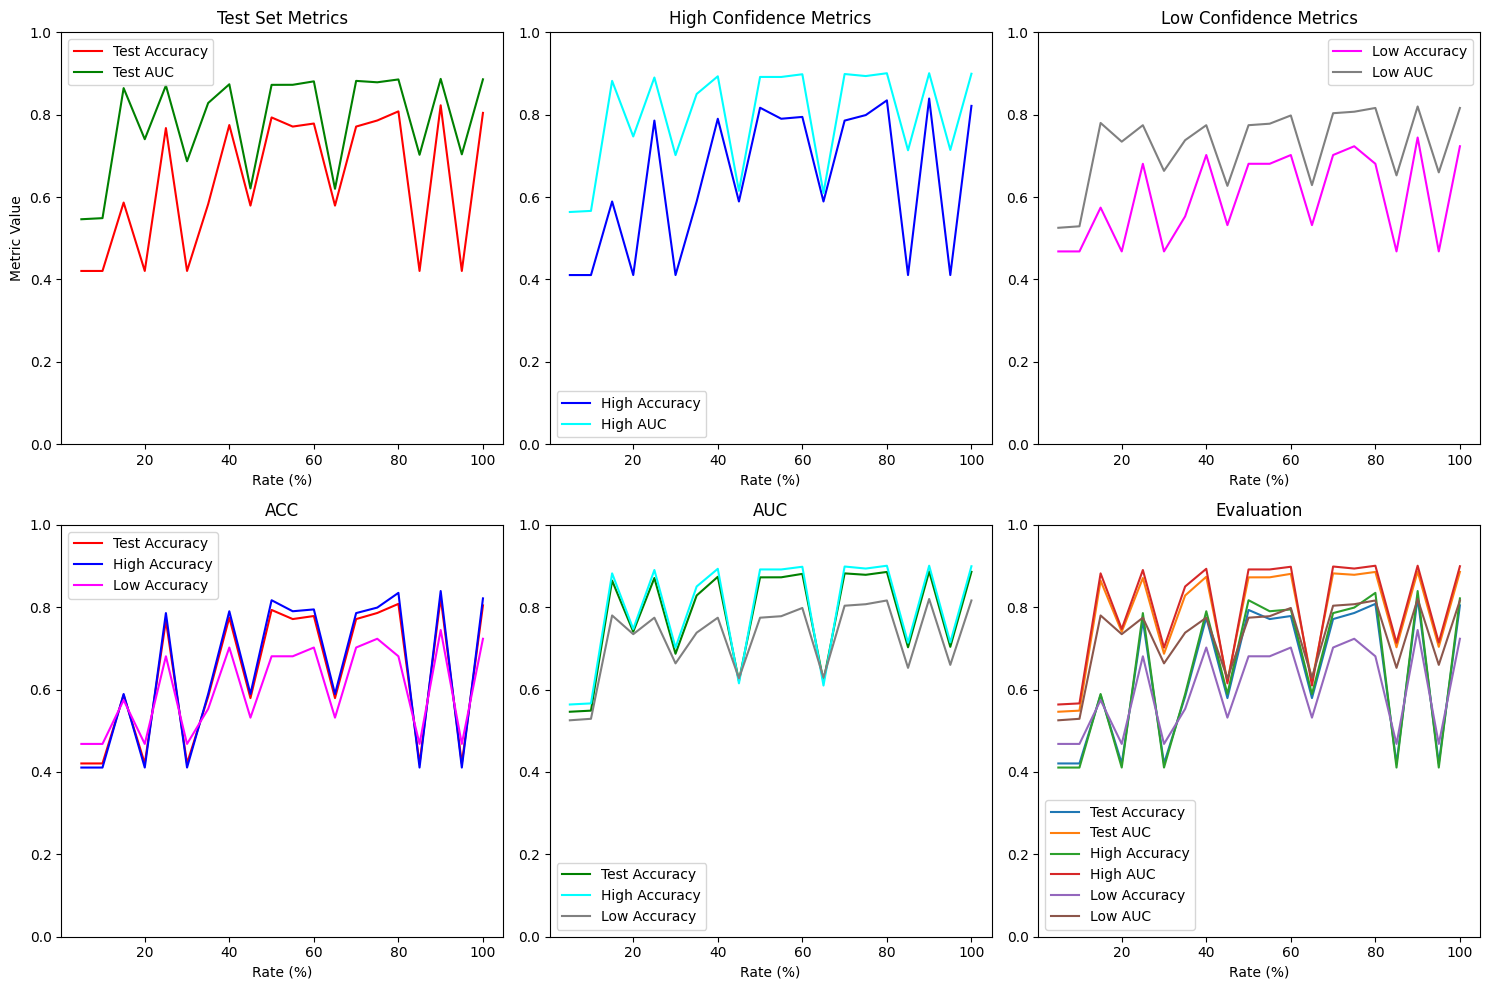

In [38]:
import matplotlib.pyplot as plt

# 计算每次迭代对应的rate值作为x轴
rate_list = [int(1 / num_iterations * (i + 1) * 100) for i in range(num_iterations)]
#rate_list.reverse()

plt.figure(figsize=(15, 10))

# 子图1: 测试集准确率和AUC
plt.subplot(2, 3, 1)  # 1行3列的子图中的第1个
plt.plot(rate_list, test_acc_list, label='Test Accuracy', color='red')
plt.plot(rate_list, test_auc_list, label='Test AUC', color='green')
plt.title('Test Set Metrics')
plt.xlabel('Rate (%)')
plt.ylabel('Metric Value')
plt.ylim(bottom=0, top=1)
plt.legend()

# 子图2: 高置信度样本准确率和AUC
plt.subplot(2, 3, 2)  # 1行3列的子图中的第2个
plt.plot(rate_list, high_acc_list, label='High Accuracy', color='blue')
plt.plot(rate_list, high_auc_list, label='High AUC', color='cyan')
plt.title('High Confidence Metrics')
plt.xlabel('Rate (%)')
plt.ylim(bottom=0, top=1)
plt.legend()

# 子图3: 低置信度样本准确率和AUC
plt.subplot(2, 3, 3)  # 1行3列的子图中的第3个
plt.plot(rate_list, low_acc_list, label='Low Accuracy', color='magenta')
plt.plot(rate_list, low_auc_list, label='Low AUC', color='grey')
plt.title('Low Confidence Metrics')
plt.xlabel('Rate (%)')
plt.ylim(bottom=0, top=1)
plt.legend()

# 子图4: ACC
plt.subplot(2, 3, 4)  
plt.plot(rate_list, test_acc_list, label='Test Accuracy', color='red')
plt.plot(rate_list, high_acc_list, label='High Accuracy', color='blue')
plt.plot(rate_list, low_acc_list, label='Low Accuracy', color='magenta')
plt.title('ACC')
plt.xlabel('Rate (%)')
plt.ylim(bottom=0, top=1)
plt.legend()

# 子图5: AUC
plt.subplot(2, 3, 5)  
plt.plot(rate_list, test_auc_list, label='Test Accuracy', color='green')
plt.plot(rate_list, high_auc_list, label='High Accuracy', color='cyan')
plt.plot(rate_list, low_auc_list, label='Low Accuracy', color='grey')
plt.title('AUC')
plt.xlabel('Rate (%)')
plt.ylim(bottom=0, top=1)
plt.legend()

# 子图6：
plt.subplot(2, 3, 6) 
plt.plot(rate_list, test_acc_list, label='Test Accuracy')
plt.plot(rate_list, test_auc_list, label='Test AUC')
plt.plot(rate_list, high_acc_list, label='High Accuracy')
plt.plot(rate_list, high_auc_list, label='High AUC')
plt.plot(rate_list, low_acc_list, label='Low Accuracy')
plt.plot(rate_list, low_auc_list, label='Low AUC')
plt.title('Evaluation')
plt.xlabel('Rate (%)')
plt.ylim(bottom=0, top=1)
plt.legend()
# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()




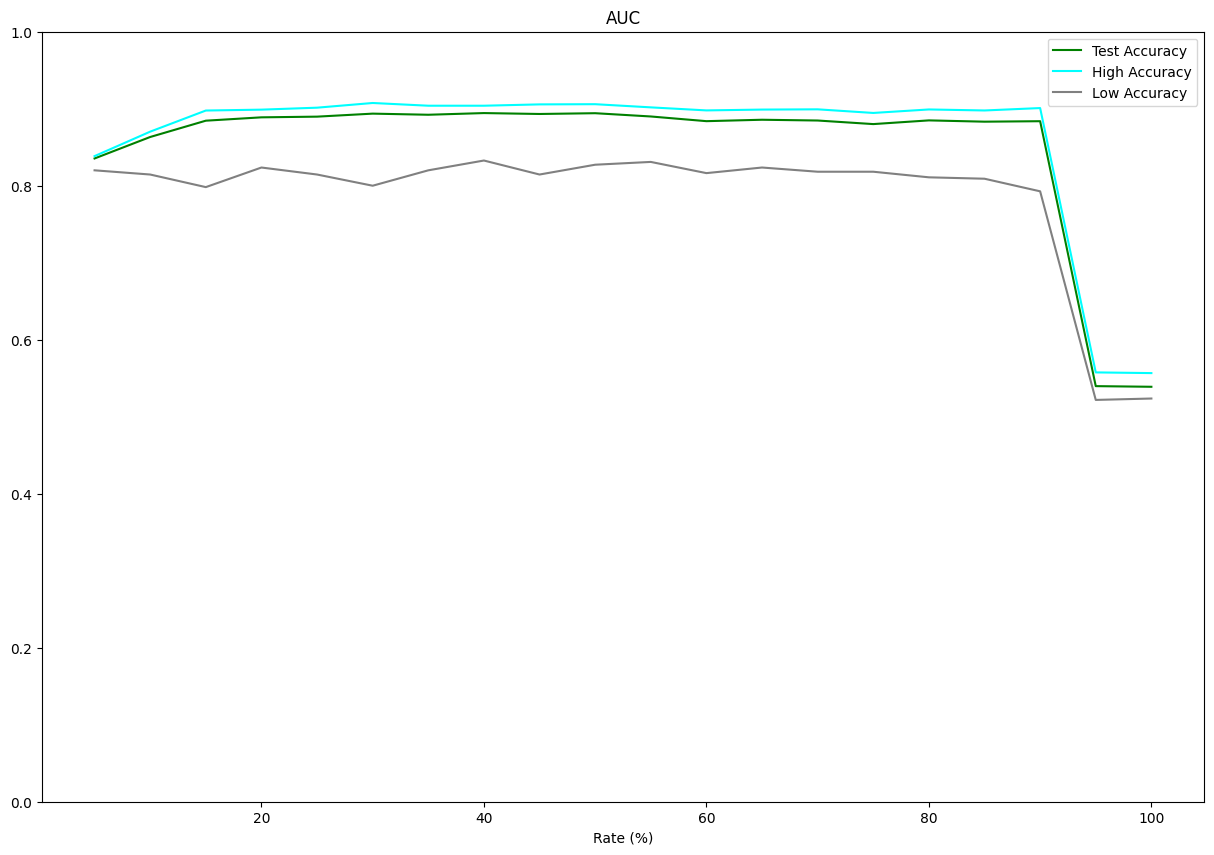

In [29]:
import matplotlib.pyplot as plt

# 计算每次迭代对应的rate值作为x轴
rate_list = [int(1 / num_iterations * (i + 1) * 100) for i in range(num_iterations)]
rate_list.reverse()

plt.figure(figsize=(15, 10))


plt.plot(rate_list, test_auc_list_2, label='Test Accuracy', color='green')
plt.plot(rate_list, high_auc_list_2, label='High Accuracy', color='cyan')
plt.plot(rate_list, low_auc_list_2, label='Low Accuracy', color='grey')
plt.title('AUC')
plt.xlabel('Rate (%)')
plt.ylim(bottom=0, top=1)
plt.legend()

# 显示图表
plt.show()

In [1]:
from torch_geometric.explain import Explainer, GNNExplainer
model.load_state_dict(torch.load(f'GCN.pth'))
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
node_index = 1
explanation = explainer(data.x, data.edge_index, edge_weight=data.edge_attr, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')


NameError: name 'model' is not defined

In [37]:
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.algorithm import PGExplainer
from torch_geometric.explain.config import ModelConfig
device = torch.device('cuda:1')
nodes = torch.tensor([0,1,2]).to(device)
model.load_state_dict(torch.load(f'GCN.pth'))
model = model.to(device)
data = data.to(device)


explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=300, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
num = torch.tensor(range(300)).to(device)
for epoch in num:
    for index in nodes:  # 需要训练的索引列表
        loss = explainer.algorithm.train(epoch, model, data.x, data.edge_index, edge_weight=data.edge_attr,
                                         target=data.y, index=index)
explanation = explainer(data.x, data.edge_index, edge_weight=data.edge_attr, target=data.y)
path = 'feature_importance_pdf.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:1! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
"""
换一个节点，计算acc在highinfo那80%里面；GAT试一下
"""